In [ ]:
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
import torch
import pandas as pd 
import numpy as np 
import collections
import matplotlib.pyplot as plt
import os 
import random as rnd
from modules.KGCN import KGCN
from modules.NeighborAggregator import NeighborAggregator
from modules.LoadData import load_data

torch.cuda.get_device_name(0)
if torch.cuda.is_available():
    device = torch.device("cuda")
  
else:
    device = torch.device("cpu")
print(device)
print(torch.cuda.get_device_name(0))

path = './'


cuda
Tesla T4
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [27]:
# Обработаем данные для начала

#Загружаем их
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, adj_entity, adj_relation,kg = load_data()

# мы хотим только понравивишиеся фильмы искать, а не классифицировать на два класса, поэтому подготавливаем данные для тренировки 
len_of_train_data_ones=0
for tri in train_data:
    if tri[2]==1:
        len_of_train_data_ones+=1
train_data_ones=np.zeros((len_of_train_data_ones,3),dtype=int)
k=0
for j,tri in enumerate(train_data):
    if tri[2]==1:
        train_data_ones[k][0] = tri[0]
        train_data_ones[k][1] = tri[1]
        train_data_ones[k][2] = tri[2]
        k+=1

#формируем юзеров,которые нужны нам для нашей модификации - когда сравниваем нового юзера с "базой юзеров" 
train_data_to_compare = dict()
for tri in train_data_ones:
    if tri[0] not in train_data_to_compare:
        train_data_to_compare[tri[0]] = []
    train_data_to_compare[tri[0]].append(tri[1])

#сохраним чтоб использовать их в файле Main.py
np.save(path + 'train_data_to_compare.npy', train_data_to_compare)

#Функция поиска максимально похожего юзера из "базы"+ если будет несколько, то выбираем рандомного
def most_common_with(new_u): 
    list_of_all_users = []
    for u in train_data_to_compare:
        equlity = len((set(new_u) & set(train_data_to_compare[u])))
        list_of_all_users.append(equlity)
    return np.random.choice(np.argwhere(list_of_all_users == np.amax(list_of_all_users)).flatten(),1)


reading rating file ...
splitting dataset ...
reading KG file ...
constructing knowledge graph ...
constructing adjacency matrix ...
data loaded.


Aggregator:  neighbor  trainig only on 1:  True
Epoch: 0.0000, Loss: 1.4335, Training accuracy: 0.4923
Epoch: 1.0000, Loss: 1.2220, Training accuracy: 0.5286
Epoch: 2.0000, Loss: 1.0658, Training accuracy: 0.5627
Epoch: 3.0000, Loss: 0.9555, Training accuracy: 0.5879
Epoch: 4.0000, Loss: 0.8702, Training accuracy: 0.6112
Epoch: 5.0000, Loss: 0.7909, Training accuracy: 0.6372
Epoch: 6.0000, Loss: 0.7130, Training accuracy: 0.6710
Epoch: 7.0000, Loss: 0.6414, Training accuracy: 0.7113
Epoch: 8.0000, Loss: 0.5805, Training accuracy: 0.7487
Epoch: 9.0000, Loss: 0.5296, Training accuracy: 0.7801
Epoch: 10.0000, Loss: 0.4858, Training accuracy: 0.8069
Epoch: 11.0000, Loss: 0.4450, Training accuracy: 0.8325
Epoch: 12.0000, Loss: 0.4054, Training accuracy: 0.8561
Epoch: 13.0000, Loss: 0.3669, Training accuracy: 0.8774
Epoch: 14.0000, Loss: 0.3302, Training accuracy: 0.8965
Epoch: 15.0000, Loss: 0.2960, Training accuracy: 0.9136
Epoch: 16.0000, Loss: 0.2646, Training accuracy: 0.9295
Epoch: 17.

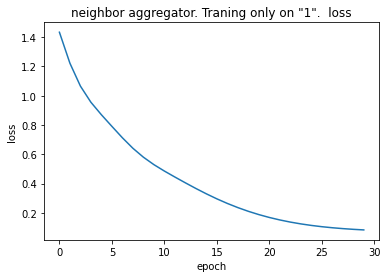

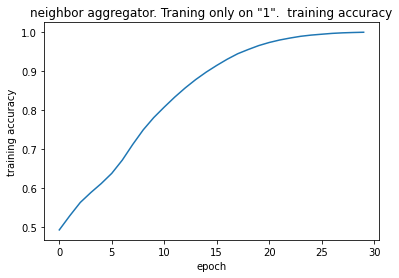

In [31]:
#тренировка для поиска наилучших настроек 
list_of_aggregators =['neighbor'] #добавляем сюда другие агреггаторы 
batch_size = 65536

for agg in list_of_aggregators:
    model=KGCN(n_user,n_entity, n_relation, adj_entity, adj_relation,batch_size,aggregator_class=agg)
    model.to(device)
    optimizer=torch.optim.Adam(model.parameters(), lr=0.02) 

    losses=[]
    accs_f1_train =[]
    print('Aggregator: ', agg, ' trainig only on 1: ', 'True')

    np.random.shuffle(train_data_ones)
    name_of_plot = agg + ' aggregator. Traning only on "1". '
    for step in range(0,30):
        model.train()
        start = 0
        total_loss=0
        k = 0
        total_f1 = 0
        optimizer.zero_grad()
        while start+batch_size<train_data_ones.shape[0]: 
            model.train()    
            user_indices = train_data_ones[start:start+batch_size,0]
            item_indices=train_data_ones[start:start+batch_size,1]
            labels_indices=train_data_ones[start:start+batch_size,2]
            out = model.forward(user_indices,item_indices,device)
            loss2 = model.loss(out,labels_indices,device)
            total_loss+=loss2
            #точность:
            f1 = model.train_acc(out)
            total_f1 +=f1
            start+=batch_size
            k+=1
        total_loss.backward()
        optimizer.step()
        losses.append(total_loss/k)
        accs_f1_train.append(total_f1/k)
        log = 'Epoch: {:.4f}, Loss: {:.4f}, Training accuracy: {:.4f}'
        print(log.format(step, total_loss/k, total_f1/k)) 
    
    plt.plot(losses)
    plt.title(name_of_plot+' loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    plt.plot(accs_f1_train)
    plt.title(name_of_plot+' training accuracy')
    plt.xlabel('epoch')
    plt.ylabel('training accuracy')
    plt.show()


In [32]:
torch.save(model,path+'model.pt')

In [33]:
#вариант когда для считаем f1,auc для юзеров из "базы"
tmp = dict() #
for tri in eval_data:
    if tri[0] not in tmp:
      tmp[tri[0]] = []
    tmp[tri[0]].append([tri[1],tri[2]])

model.eval()    
user_indices = eval_data[:,0]
item_indices=eval_data[:,1]
labels_indices=eval_data[:,2]
auc_all = 0 
f1_all = 0
k=0
for g in tmp:
    item_indices = []
    labels_indices=[]
    for x in tmp[g]:
        item_indices.append(x[0])
        labels_indices.append(x[1])
    user_indices=[g]*len(labels_indices)
    if not (labels_indices==[1]*len(labels_indices) or labels_indices==[0]*len(labels_indices) ): #f1 не считается когда только один класс представлен
        out_val = model.inference(user_indices,item_indices,device)
        auc , f1 = model.ctr(out_val,labels_indices)
        auc_all+=auc
        f1_all+=f1
        k+=1
print('Auc: ', auc_all/k,'f1: ', f1_all/k)

Auc:  0.5062945997835392 f1:  0.6556840729757247


In [34]:
#А теперь готовим данные, нужные только для расчета точности нашего модифицированного метода  AA
eval_data_cool = list (map (lambda x: [x[0], x[1]], filter (lambda x: x[2] == 1, eval_data)))
eval_data_super = pd.DataFrame(eval_data_cool, columns=["user_id", "film_id"]).groupby("user_id")["film_id"].apply(list).to_dict()
def for_each_dict(f,d):
    for k, v in d.items():
        f(v)
def map_dict(f,d):
    r = dict()
    for k, v in d.items():
        r[k] = f(v)
    return r
def split_list(list, k):
    kek = int(len(list) * k + .5)
    return (list[:kek], list[kek:])

(for_each_dict(lambda x: rnd.shuffle(x),eval_data_super))
eval_data_super_dict = map_dict(lambda x: split_list(x, 0.7),eval_data_super)
eval_to_compare, eval_save = map_dict(lambda x: x[0], eval_data_super_dict), map_dict(lambda x: x[1], eval_data_super_dict)
eval_to_find_acc= list(filter(lambda x: (x[2] == 0) or (not (x[1] in eval_to_compare[x[0]])), eval_data))
for j,k in enumerate(eval_to_find_acc):
    eval_to_find_acc[j]=eval_to_find_acc[j].tolist()
eval_to_find_acc= np.array(eval_to_find_acc)

eval_to_find=dict()
for tri in eval_to_find_acc:
    if tri[0] not in eval_to_find:
        eval_to_find[tri[0]]=[]
    eval_to_find[tri[0]].append(([tri[1],tri[2]]))

item_indices=dict() #ключ - юзер, значения - индексы фильмов для которых есть оценка
labels_indices=dict() #ключ - юзер, значения - в соответствубщем порядке оценка фильмам
u_to_delete=[] 

for u in eval_to_compare:
    if u not in eval_to_find:
        u_to_delete.append(u)
    else:
        item_indices.update({u:np.array(eval_to_find[u])[:,0].tolist()})
        labels_indices.update({u:np.array(eval_to_find[u])[:,1].tolist()})
    
for u in u_to_delete:
    eval_to_compare.pop(u)

In [ ]:
#Теперь находим наиболее похожих юзеров, и считаем f1,auc для них
accs=[]
aucs = []
k=0
model.eval() 
  for u in eval_to_compare:
    ind = most_common_with(eval_to_compare[u])
    user_indices = ind.tolist()*len(labels_indices[u])
    auc_all = 0 
    f1_all = 0

    if not (labels_indices[u]==[1]*len(labels_indices[u]) or labels_indices[u]==[0]*len(labels_indices[u]) ):
        out_val = model.inference(user_indices,item_indices[u],device)
        auc , f1 = model.ctr(out_val,labels_indices[u])
        print(k)
        accs.append(f1)
        aucs.append(auc)
        auc_all+=auc
        f1_all+=f1
        k+=1


In [39]:
print('Auc for new user', sum(aucs)/k,'f1 for new users', sum(accs)/k)

Auc for new user 0.512563907393718 f1 for new users 0.40131936906734156
